In [1]:
import pandas as pd
from elasticsearch.helpers import scan
import numpy as np
import matplotlib.pyplot as plt
import helpers as hp

extended_period = ['2024-08-01T06:22:19.000Z', '2024-08-20T06:22:19.000Z']
bin_hours = 4

results = []
q = {
    "query": {
      "bool": {
        "must": [
          {
          "range": {
            "throughput_ts": {
              "format": "strict_date_optional_time",
              "lte": extended_period[1],
              "gte": extended_period[0]
            }
          }
          },
          {
            "term": {
              "ipv6": False
            }
          }
        ]
      }
    }
    }
data = scan(hp.es, index='routers', query=q)
for item in data:
    results.append(item['_source'])

if results:
    df = pd.DataFrame(results)


df.head()

Success


,traceroute_ts,throughput_ts,ttls-hops_hash,src,dest,throughput_Mb,path_complete,destination_reached,route-sha1,ipv6,src_host,dest_host,router,ttl,asn,rtt,src_site,dest_site,similarity_score,stable
0,2024-08-08T21:48:50.000Z,2024-08-08T21:47:39.000Z,1a761ff85a972cf85c459bc7dc32337820ae02db,194.80.35.168,145.100.32.32,679,True,True,dd2a48c414d642b774d9d3f0c6c40eca910ca364,False,pygrid-sonar1.lancs.ac.uk,perfsonar-bandwidth.grid.surfsara.nl,146.97.33.17,6,786,8.0,UKI-NORTHGRID-LANCS-HEP,SARA-MATRIX,0.994,False
1,2024-08-08T21:48:50.000Z,2024-08-08T21:47:39.000Z,1a761ff85a972cf85c459bc7dc32337820ae02db,194.80.35.168,145.100.32.32,679,True,True,dd2a48c414d642b774d9d3f0c6c40eca910ca364,False,pygrid-sonar1.lancs.ac.uk,perfsonar-bandwidth.grid.surfsara.nl,62.40.124.197,7,20965,7.9,UKI-NORTHGRID-LANCS-HEP,SARA-MATRIX,0.994,False
2,2024-08-08T21:48:50.000Z,2024-08-08T21:47:39.000Z,1a761ff85a972cf85c459bc7dc32337820ae02db,194.80.35.168,145.100.32.32,679,True,True,dd2a48c414d642b774d9d3f0c6c40eca910ca364,False,pygrid-sonar1.lancs.ac.uk,perfsonar-bandwidth.grid.surfsara.nl,62.40.98.60,8,20965,7.9,UKI-NORTHGRID-LANCS-HEP,SARA-MATRIX,0.994,False
3,2024-08-08T21:48:50.000Z,2024-08-08T21:47:39.000Z,1a761ff85a972cf85c459bc7dc32337820ae02db,194.80.35.168,145.100.32.32,679,True,True,dd2a48c414d642b774d9d3f0c6c40eca910ca364,False,pygrid-sonar1.lancs.ac.uk,perfsonar-bandwidth.grid.surfsara.nl,62.40.98.22,9,20965,19.6,UKI-NORTHGRID-LANCS-HEP,SARA-MATRIX,0.994,False
4,2024-08-08T21:48:50.000Z,2024-08-08T21:47:39.000Z,1a761ff85a972cf85c459bc7dc32337820ae02db,194.80.35.168,145.100.32.32,679,True,True,dd2a48c414d642b774d9d3f0c6c40eca910ca364,False,pygrid-sonar1.lancs.ac.uk,perfsonar-bandwidth.grid.surfsara.nl,62.40.98.38,10,20965,12.7,UKI-NORTHGRID-LANCS-HEP,SARA-MATRIX,0.994,False


In [2]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

# Connect to the running Dask cluster using the scheduler address
client = Client('tcp://127.0.0.1:40061')


df.sort_values(by=['traceroute_ts', 'ttls-hops_hash', 'ttl'], inplace=True)
df['anonymous'] = 0
df['max_ttl'] = df.groupby('ttls-hops_hash')['ttl'].transform(max)
ddf = dd.from_pandas(df, npartitions=8)


# Define the function to fill missing TTLs
def fill_missing_ttl(group):
    group = group.sort_values(by='ttl')
    complete_range = pd.RangeIndex(start=group['ttl'].min(), stop=group['ttl'].max() + 1)

    missing_ttl = complete_range.difference(group['ttl'])

    rows_to_add = []
    for ttl in missing_ttl:
        previous_row = group.iloc[0]
        new_row = previous_row.copy()
        new_row['ttl'] = ttl
        new_row['anonymous'] = 1
        new_row['router'] = 'unknown'
        rows_to_add.append(new_row)

    return pd.concat([group, pd.DataFrame(rows_to_add)], ignore_index=True).sort_values(by='ttl')



# Grouping and applying the function using Dask's map_partitions
# Convert the grouped Dask DataFrame back to pandas for processing
def process_partition(partition):
    # Group by traceroute_ts and ttls-hops_hash within each partition
    return partition.groupby(['traceroute_ts', 'ttls-hops_hash']).apply(fill_missing_ttl)

# Use map_partitions to parallelize the function across partitions
filled_dask = ddf.map_partitions(process_partition, meta=df)

# Step 3: Convert back to pandas DataFrame if needed
filled_ipv4 = filled_dask.compute()
filled_ipv4.drop(columns=['traceroute_ts', 'ttls-hops_hash'], inplace=True)
filled_ipv4.reset_index(inplace=True)

/usr/local/lib/python3.8/dist-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 66.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [3]:
# Without Dask
# df.sort_values(by=['traceroute_ts', 'ttls-hops_hash', 'ttl'], inplace=True)
# df['anonymous'] = 0


# def fill_missing_ttl(group):
#     group = group.sort_values(by='ttl')
#     complete_range = pd.RangeIndex(start=group['ttl'].min(), stop=group['ttl'].max() + 1)

#     missing_ttl = complete_range.difference(group['ttl'])

#     rows_to_add = []
#     for ttl in missing_ttl:
#         previous_row = group.iloc[0]
#         new_row = previous_row.copy()
#         new_row['ttl'] = ttl
#         new_row['anonymous'] = 1
#         new_row['router'] = 'unknown'
#         rows_to_add.append(new_row)

#     return pd.concat([group, pd.DataFrame(rows_to_add)], ignore_index=True).sort_values(by='ttl')

# filled_ipv4 = df.groupby(['traceroute_ts', 'ttls-hops_hash']).apply(fill_missing_ttl).reset_index(drop=True)

# filled_ipv4['max_ttl'] = filled_ipv4.groupby('ttls-hops_hash')['ttl'].transform(max)



In [4]:
import random
import plotly.graph_objects as go

def generate_plotly_heatmap_with_hover(df, src_site, dest_site):
    df.sort_values('traceroute_ts', inplace=True)
    # Filter the DataFrame for the specified source and destination site
    filtered_df = df[(df['src_site'] == src_site) & (df['dest_site'] == dest_site)][['ttls-hops_hash', 'router', 'ttl', 'destination_reached']].drop_duplicates()

    # Pivot the DataFrame
    pivot_df = filtered_df.pivot(index='ttls-hops_hash', columns='ttl', values='router')

    # Get unique routers including 'unknown'
    unique_routers = pd.Series(pivot_df.stack().unique()).dropna().tolist()

    cmap = plt.get_cmap('hsv', len(unique_routers) + 1)
    colors = [f"rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 0.6)" for c in cmap(np.arange(len(unique_routers)))]

    # Shuffle the colors to prevent similar IPs from getting similar colors
    if len(unique_routers)>20:
        random.shuffle(colors)

    # Ensure 'unknown' is black and missing values are white
    color_list = ['#FFFFFF'] + colors
    if 'unknown' in unique_routers:
        color_list[unique_routers.index('unknown') + 1] = 'rgba(0, 0, 0, 1)'  # Full opacity black for unknown


    # Replace routers with their corresponding index in the unique_routers list
    router_to_index = {router: i for i, router in enumerate(unique_routers)}
    index_df = pivot_df.applymap(lambda x: router_to_index[x] if pd.notna(x) else -1)

    destination_reached = filtered_df[['ttls-hops_hash', 'destination_reached']].drop_duplicates()
    destination_reached.set_index('ttls-hops_hash', inplace=True)


    hover_text = pivot_df.applymap(lambda x: f"Router: {x}" if pd.notna(x) else "Missing").values

    fig = go.Figure()

    heatmap = go.Heatmap(
        z=index_df.values,
        x=index_df.columns,
        y=index_df.index,
        colorscale=color_list,
        zmin=-1,
        zmax=len(unique_routers) - 1,
        text=hover_text,
        hoverinfo='text',
        showscale=False,
        xgap=1,
        ygap=1,
    )

    fig.add_trace(heatmap)

    fig.update_layout(
        title=f"Path signature between {src_site} and {dest_site}",
        xaxis_title='TTL',
        yaxis_title='Path Identifier (ttls-hops_hash)',
    )

    # second Y-axis as annotations for 'destination_reached'
    annotations = []
    for i, (path_id, reached) in enumerate(destination_reached.itertuples()):
        annotations.append(dict(
            xref='paper',
            yref='y',
            x=1.05,
            y=i,
            xanchor='left',
            text=str(reached),
            showarrow=False
        ))

    annotations.append(dict(
        xref='x domain',
        yref='paper',
        x=1.02,
        y=1.1,
        xanchor='left',
        text='Destination Reached',
        showarrow=False,
        font=dict(size=12, color='black')
    ))

    fig.update_layout(
        annotations=annotations,
        margin=dict(r=250),
        height=600, width=1400
    )

    fig.show()


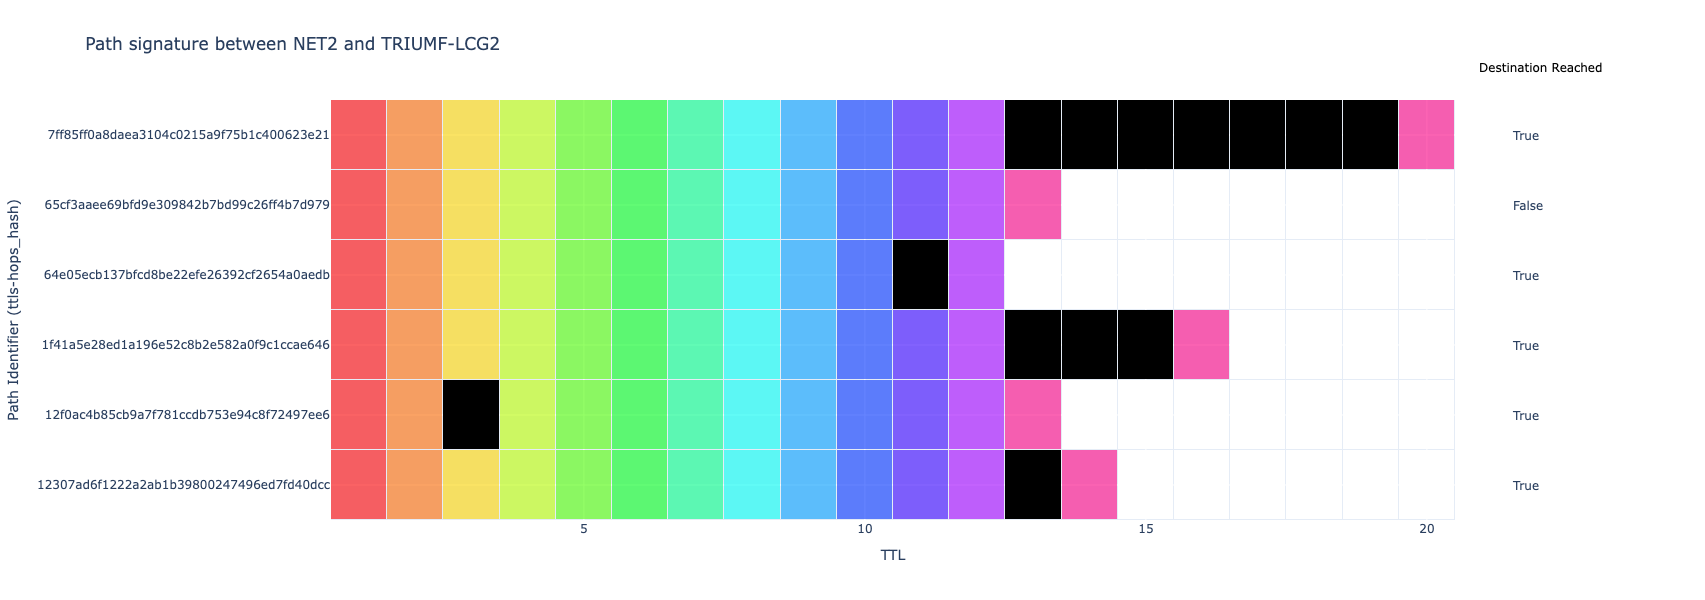

In [8]:
src, dest = filled_ipv4[filled_ipv4['router']=='unknown'][['src_site','dest_site']].drop_duplicates().sample(1).values.tolist()[0]
generate_plotly_heatmap_with_hover(filled_ipv4,  src, dest)